In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import spacy
from textblob import TextBlob
%matplotlib inline

In [2]:
#import all the SOTU txt files
data_folder = 'state-of-the-union-corpus-1989-2017'
file_list = [os.path.join(data_folder, fn) for fn in os.listdir(data_folder)]

#create lists for the year and President who gave the speech
years = []
potus = []
for file in os.listdir(data_folder):
    year = file[:4]
    pres = file[5:-4]
    pres = re.sub('[^a-zA-Z]+', '', pres)
    years.append(year)
    potus.append(pres)

In [3]:
#create dataframe
df = pd.DataFrame(file_list, columns=['path'])
df['year'] = years
df['year'] = df['year'].astype(int)
df['president'] = potus

#create a list of Democrat presidents
dems = ['Truman', 'Kennedy', 'Johnson', 'Carter', 'Clinton', 'Obama']
#add party affiliation to the dataframe
df['party'] = df.president.apply(lambda x: 'Democrat' if x in dems else 'Republican')

In [4]:
#use textblob to tokenize the words in each speech
df['tokens'] = df.path.apply(lambda x: TextBlob(open(x, encoding='ISO-8859-1').read()).words)
#use textblob to perform a sentiment analysis of each speech
df['sentiment'] = df.path.apply(lambda x: TextBlob(open(x, encoding='ISO-8859-1').read()).sentiment.polarity)

df.head()

,path,year,president,party,tokens,sentiment
0,state-of-the-union-corpus-1989-2017\1945-Truma...,1945,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ADDRESS, BEF...",0.103764
1,state-of-the-union-corpus-1989-2017\1946-Truma...,1946,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, MESSAGE, TO,...",0.111545
2,state-of-the-union-corpus-1989-2017\1947-Truma...,1947,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.136731
3,state-of-the-union-corpus-1989-2017\1948-Truma...,1948,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.165403
4,state-of-the-union-corpus-1989-2017\1949-Truma...,1949,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.155075


In [5]:
#check data types
df.dtypes

path          object
year           int32
president     object
party         object
tokens        object
sentiment    float64
dtype: object

In [6]:
#import GDP growth data since 1945
gdp_df = pd.read_csv('gdp_data.csv')
gdp_df['Date'] = pd.to_datetime(gdp_df['Date'])
gdp_df['year'] = gdp_df.Date.apply(lambda x: x.year).astype(int)
gdp_df['GDP Growth Rate'] = gdp_df['GDP Growth Rate'].apply(lambda x: x * 100)
gdp_df.sort_values(by='year', inplace=True)
gdp_df = gdp_df.reset_index()

df['gdp_rate'] = gdp_df['GDP Growth Rate']

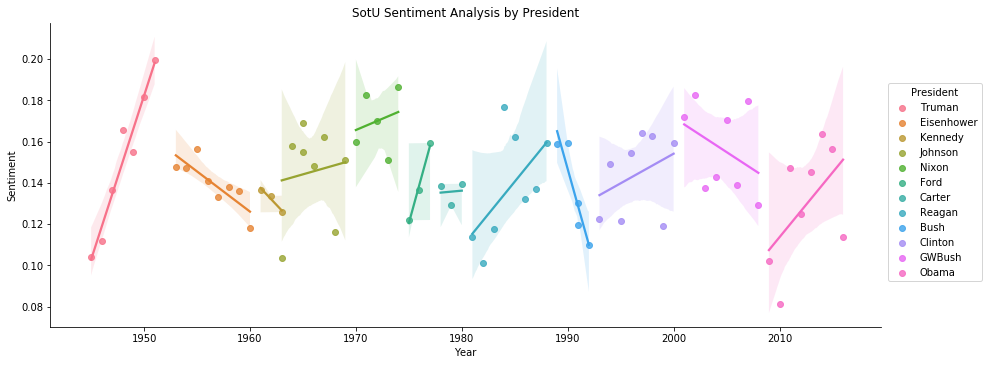

In [7]:
#plot sentiment analysis data
g = sns.lmplot(x="year", y="sentiment", hue="president", aspect=2.5, truncate=True, data=df)
g._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('SotU Sentiment Analysis by President')

plt.show()

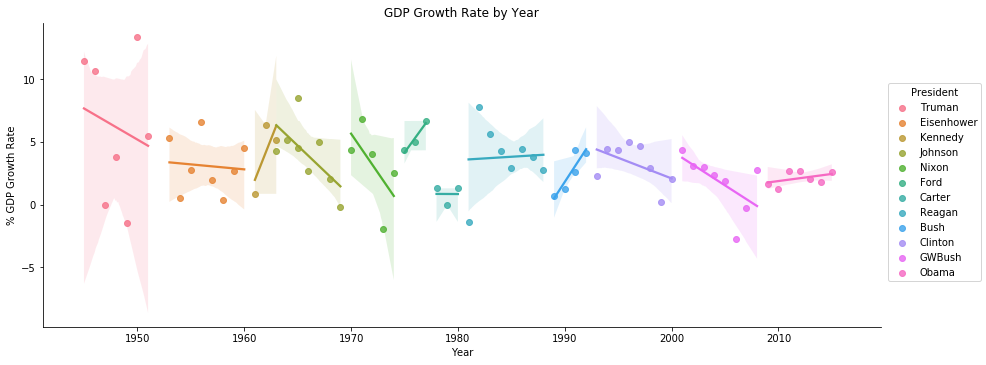

In [8]:
#plot GDP growth data
g1 = sns.lmplot(x="year", y="gdp_rate", hue="president", aspect=2.5, truncate=True, data=df)
g1._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% GDP Growth Rate')
plt.title('GDP Growth Rate by Year')

plt.show()

In [9]:
#utility function to clean text
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--', get rid of it
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in brakets.
    text = re.sub('[\[].*?[\]]', '', text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text

In [10]:
#load spacy model
nlp = spacy.load('en_core_web_sm')

#add features with text for each speech and run through the text cleaner
df['text'] = df.path.apply(lambda x: open(x, encoding='ISO-8859-1').read())
df['text'] = df.text.apply(lambda x: text_cleaner(x))

In [11]:
df['nlp'] = df.text.apply(lambda x: nlp(x))
df.head()

,path,year,president,party,tokens,sentiment,gdp_rate,text,nlp
0,state-of-the-union-corpus-1989-2017\1945-Truma...,1945,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ADDRESS, BEF...",0.103764,11.45,PRESIDENT HARRY S. TRUMAN'S ADDRESS BEFORE A J...,"(PRESIDENT, HARRY, S., TRUMAN, 'S, ADDRESS, BE..."
1,state-of-the-union-corpus-1989-2017\1946-Truma...,1946,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, MESSAGE, TO,...",0.111545,10.67,PRESIDENT HARRY S. TRUMAN'S MESSAGE TO THE CON...,"(PRESIDENT, HARRY, S., TRUMAN, 'S, MESSAGE, TO..."
2,state-of-the-union-corpus-1989-2017\1947-Truma...,1947,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.136731,-0.01,PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...,"(PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES..."
3,state-of-the-union-corpus-1989-2017\1948-Truma...,1948,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.165403,3.80,PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...,"(PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES..."
4,state-of-the-union-corpus-1989-2017\1949-Truma...,1949,Truman,Democrat,"[PRESIDENT, HARRY, S, TRUMAN, 'S, ANNUAL, MESS...",0.155075,-1.50,PRESIDENT HARRY S. TRUMAN'S ANNUAL MESSAGE TO ...,"(PRESIDENT, HARRY, S., TRUMAN, 'S, ANNUAL, MES..."


In [12]:
#save a list of stop words
stop_words = stopwords.words('english')

#utility function that retuns a list of the most common words
def word_frequencies(text, include_stop=False):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in text:
        #exclude punctuation, numeric characters and words in the stop list
        if not token.is_punct and token.is_alpha and not token.is_stop and token.lower_ not in stop_words:
            words.append(token.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)

In [13]:
from collections import Counter

#use word frequency function to return the top 10 words used in each speech
freq_list = []
for speeches in df.nlp:
    sotus_freq = word_frequencies(speeches, include_stop=False).most_common(10)
    freq_list.append(sotus_freq)
    
for a, b, c in zip(df.president, df.year, freq_list):
    print(a, b, c)

Truman 1945 [('peace', 23), ('world', 20), ('America', 11), ('people', 10), ('nations', 10), ('hope', 8), ('freedom', 7), ('great', 6), ('shall', 6), ('man', 5)]
Truman 1946 [('dollars', 207), ('year', 181), ('war', 165), ('million', 137), ('fiscal', 125), ('expenditures', 93), ('United', 91), ('program', 90), ('Government', 90), ('billion', 83)]
Truman 1947 [('Congress', 27), ('labor', 26), ('national', 22), ('program', 21), ('management', 18), ('Government', 17), ('war', 16), ('year', 15), ('world', 15), ('housing', 14)]
Truman 1948 [('world', 29), ('economic', 23), ('people', 22), ('great', 17), ('Nation', 15), ('Congress', 14), ('program', 14), ('tax', 14), ('United', 13), ('States', 13)]
Truman 1949 [('Congress', 17), ('Government', 17), ('people', 15), ('world', 14), ('prosperity', 12), ('production', 12), ('good', 10), ('great', 10), ('housing', 10), ('economy', 9)]
Truman 1950 [('world', 27), ('Congress', 20), ('economic', 19), ('years', 18), ('life', 17), ('great', 15), ('peop

Bush 1991 [('world', 29), ('America', 20), ('know', 18), ('American', 17), ('freedom', 14), ('future', 14), ('people', 13), ('power', 12), ('States', 11), ('new', 10)]
Bush 1991 [('world', 24), ('war', 20), ('peace', 15), ('people', 13), ('American', 12), ('home', 12), ('new', 12), ('time', 10), ('Let', 10), ('America', 9)]
Bush 1992 [('people', 26), ('know', 24), ('world', 23), ('plan', 23), ('right', 19), ('American', 18), ('country', 17), ('new', 17), ('help', 17), ('Congress', 14)]
Clinton 1993 [('people', 45), ('new', 29), ('American', 28), ('plan', 26), ('country', 26), ('Government', 24), ('care', 24), ('jobs', 24), ('work', 23), ('year', 22)]
Clinton 1994 [('people', 63), ('health', 41), ('care', 40), ('work', 34), ('year', 31), ('Congress', 24), ('American', 22), ('world', 22), ('know', 22), ('country', 21)]
Clinton 1995 [('people', 73), ('work', 42), ('Government', 35), ('country', 34), ('years', 29), ('year', 29), ('time', 28), ('way', 28), ('new', 27), ('know', 26)]
Clinton

In [14]:
from wordcloud import WordCloud

#function that will create a word cloud for each of of the speeches
def word_clouds(text_list):
    plt.figure(figsize=(15, 100))
    n = 0
    x = 1
    for texts in text_list:
        plt.subplot(40, 2, x)
        wordcloud = WordCloud(stopwords=stop_words, max_words=20).generate(texts)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(df.president[n] + ' ' + str(df.year[n]))
        plt.axis("off")
        n += 1
        x += 1
    plt.tight_layout()
    plt.show()

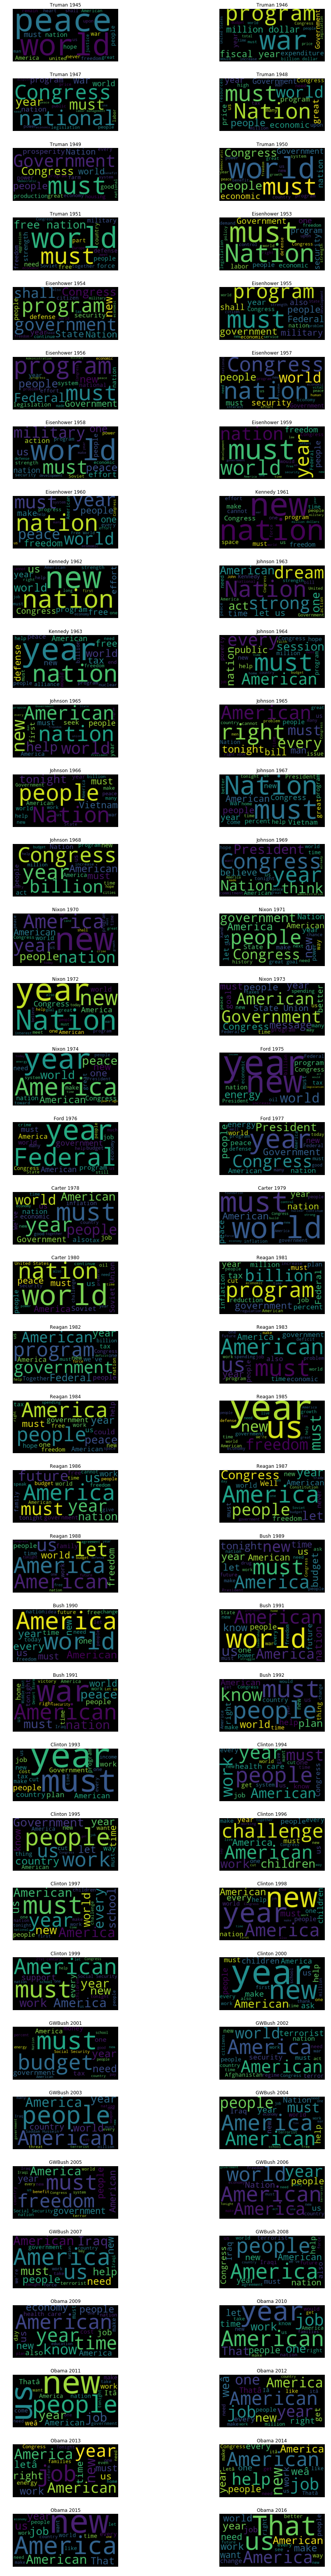

In [15]:
word_clouds(df.text)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

X_train, X_test, y_train, y_test = train_test_split(df.text, df.path, test_size=0.4, random_state=0)

#build TFIDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the speeches
                             min_df=5, # only use words that appear at least five times
                             stop_words='english', #remove stop words
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#inverse document frequencies in our weighting
                             norm=u'l2', #a correction factor so that longer and shorter speeches get treated equally
                             smooth_idf=True #prevents divide-by-zero errors
                            )

In [17]:
#Applying the vectorizer
sotus_tfidf = vectorizer.fit_transform(df.text)
print("Number of features: %d" % sotus_tfidf.get_shape()[1])

Number of features: 3845


In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 3845 to 65.
svd= TruncatedSVD(65)
lsa = make_pipeline(svd, Normalizer(copy=False))
#Run SVD on the sotus data, then project
sotus_lsa = lsa.fit_transform(sotus_tfidf)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

xs, ys = sotus_lsa[:, 0], sotus_lsa[:, 1]

Explained variance of the SVD step: 93%


In [19]:
file_list = []
for paths in df.path:
    path, file = paths.split('\\')
    file_list.append(file)
    
#feature names
terms = vectorizer.get_feature_names()

In [20]:
#build a Kmeans cluster with two clusters
km = KMeans(n_clusters=2, random_state=42)
km.fit(sotus_tfidf)
clusters = km.labels_.tolist()

df['cluster'] = clusters

In [21]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(2):
    print("Cluster %d words:" % i, end=' ')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(terms[ind], end=', ')
    print('\n')

Top terms per cluster:

Cluster 0 words: shall, expenditures, farm, vietnam, recommend, recommendations, communist, peoples, aggression, employment, management, adequate, period, capacity, oil, reduction, xand, affairs, organization, mutual, 

Cluster 1 words: ll, iraq, don, parents, businesses, college, terrorists, 21st, medicare, bipartisan, kids, cuts, got, tell, class, terror, drugs, afghanistan, big, iraqi, 



In [23]:
#create data frame that has the cluster numbers and titles
kmean_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=file_list, party=df.party)) 

#group by cluster
groups = kmean_df.groupby('label')

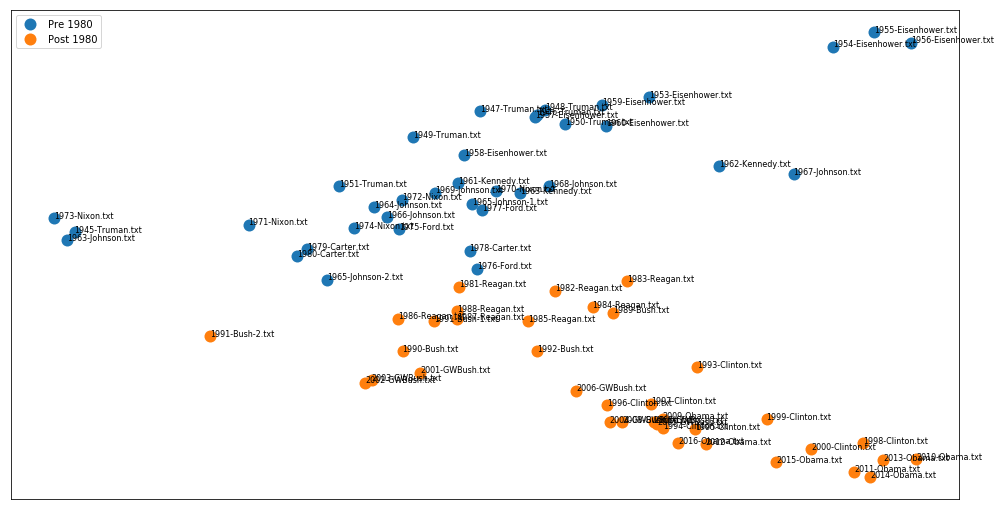

In [24]:
cluster_names = {0: 'Pre 1980', 1: 'Post 1980'}

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], #color='blues',
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df.loc[i]['x'], kmean_df.loc[i]['y'], kmean_df.loc[i]['title'], size=8)  

    
    
plt.show()

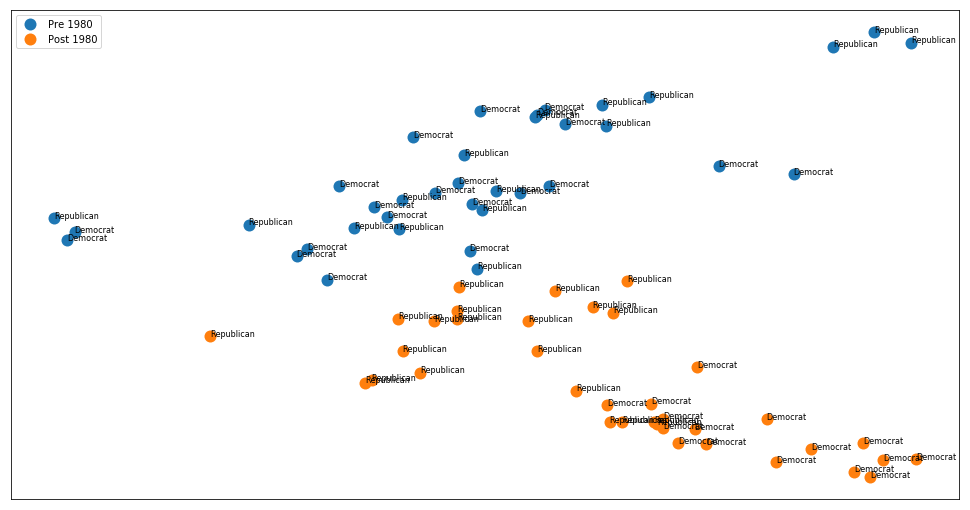

In [25]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df.loc[i]['x'], kmean_df.loc[i]['y'], kmean_df.loc[i]['party'], size=8)  

    
    
plt.show()

In [26]:
#Kmeans with 4 clusters
km1 = KMeans(n_clusters=4, random_state=420)
km1.fit(sotus_tfidf)
clusters1 = km1.labels_.tolist()

df['cluster1'] = clusters1

In [27]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids1 = km1.cluster_centers_.argsort()[:, ::-1] 

for i in range(4):
    print("Cluster %d words:" % i, end=' ')
    
    for ind in order_centroids1[i, :20]: #replace 6 with n words per cluster
        print(terms[ind], end=', ')
    print('\n')

Top terms per cluster:

Cluster 0 words: iraq, terrorists, iraqi, terror, saddam, al, terrorist, victory, hussein, qaeda, gulf, afghanistan, iraqis, coalition, regime, medicare, relief, enemy, enemies, funding, 

Cluster 1 words: ll, space, dream, tell, deficits, recovery, regulations, dreams, revolution, reduction, strategic, nicaragua, don, asking, yes, waste, bipartisan, excellence, leader, kennedy, 

Cluster 2 words: shall, expenditures, recommend, farm, vietnam, communist, recommendations, peoples, aggression, management, period, adequate, reduction, oil, employment, affairs, concern, agriculture, foundation, capacity, 

Cluster 3 words: college, businesses, ll, don, parents, 21st, class, got, companies, ought, kids, cuts, invest, donâ, bipartisan, medicare, global, students, republicans, democrats, 



In [28]:
cluster_names1 = {0: 'GW Bush', 1: 'Post 1980', 2: 'Pre 1980', 3: 'Post 1990 Democrats'}

#create data frame that has the cluster numbers and titles
kmean_df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters1, title=file_list, party=df.party)) 

#group by cluster
groups1 = kmean_df1.groupby('label')

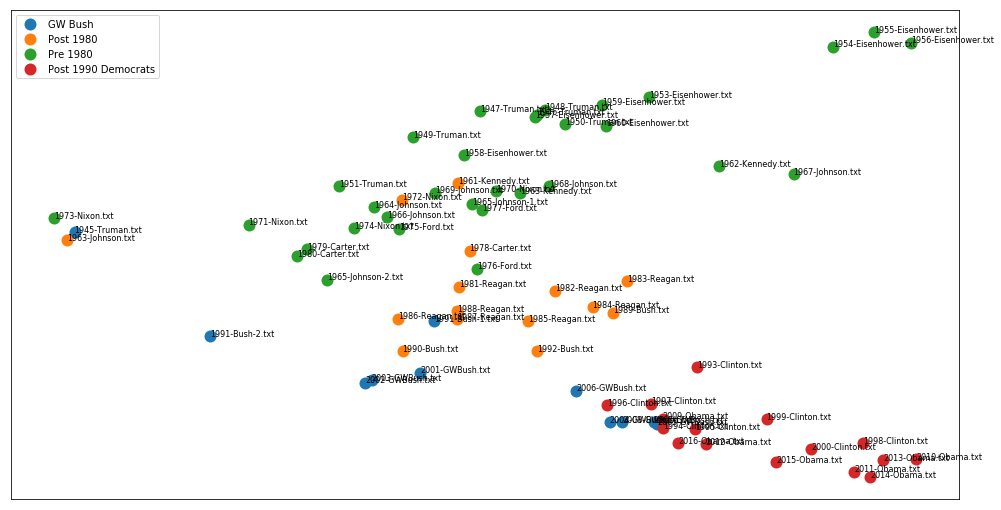

In [29]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups1:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names1[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(kmean_df1.loc[i]['x'], kmean_df1.loc[i]['y'], kmean_df1.loc[i]['title'], size=8)  

    
    
plt.show()

In [30]:
from sklearn.cluster import SpectralClustering

#set up a spectral clustering model using 4 clusters
sc = SpectralClustering(n_clusters=4, random_state=1337)
sc.fit(sotus_tfidf)

#Predicted clusters.
predict=sc.fit_predict(sotus_tfidf)

clusters2 = sc.labels_.tolist()

In [31]:
cluster_names2 = {0: '1960-1990', 1: 'Post 1990 Democrats', 2: 'GW Bush', 3: 'Pre 1960'}

#create data frame that has the result of the MDS plus the cluster numbers and titles
sc_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters2, title=file_list, party=df.party)) 

#group by cluster
groups2 = sc_df.groupby('label')

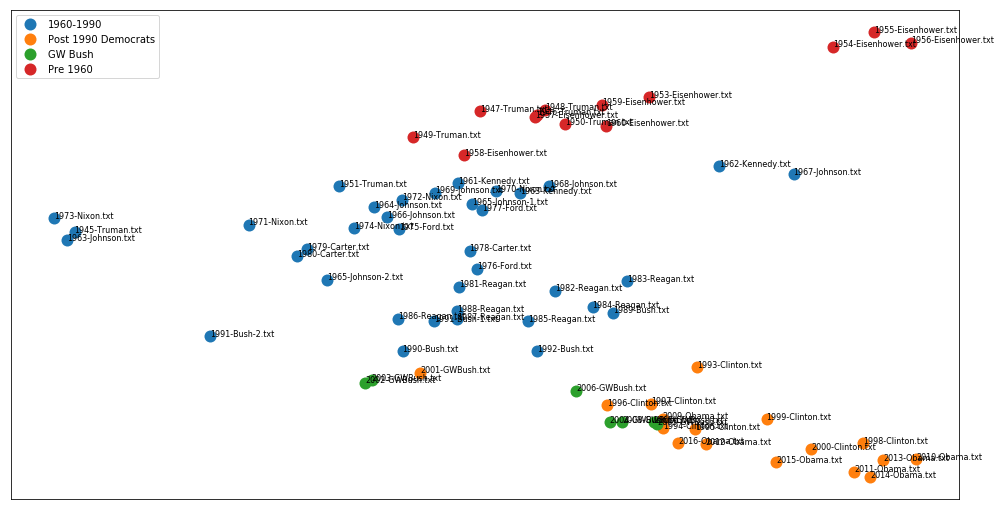

In [32]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups2:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names2[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(df)):
    ax.text(sc_df.loc[i]['x'], sc_df.loc[i]['y'], sc_df.loc[i]['title'], size=8)  

    
    
plt.show()